In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

### Basic Multi-Head Latent Attention (Without RoPE)

In [2]:
class MLA(nn.Module):
    def __init__(self,d_model,n_heads,kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.kv_dim_model = kv_latent_dim
        self.dh = d_model // n_heads ## dim per head
        
        ## Projection layers
        self.W_q   = nn.Linear(d_model,d_model,bias=False) ## Queries Projection matrix 
        self.W_dkv = nn.Linear(d_model,kv_latent_dim,bias=False) ## Latent Projection Matrix
        self.W_uk  = nn.Linear(kv_latent_dim,d_model,bias=False) ## Keys decompression matrix (from latent dimension to the d_model dimension ) 
        self.W_uv  = nn.Linear(kv_latent_dim,d_model,bias=False) ## Values decompression matrix (from latent dimension to the d_model dimension )
        self.W_o   = nn.Linear(d_model,d_model,bias=False) ## Final Projection layer 
        
        self.ln = nn.LayerNorm(kv_latent_dim)
        self.register_buffer("absorbed_k",None) ## holds W_q @ W_uk
        
    def forward(self,x,kv_cache=None,past_length=0):
        b,s,d = x.size()
        ## compute absorbed_k once : W_q @ W_uk (W_q * W_uk.T) (d_model,d_model) * (d_model,kv_latent_dim) = (d_model,kv_latent_dim)
        if self.absorbed_k is None : 
            absorbed = torch.matmul(self.W_q.weight,self.W_uk.weight) # (d_model,kv_latent_dim)
            self.absorbed_k = absorbed.view(self.n_heads,self.dh,-1)  # (n_heads,dh,kv_latent_dim)
        ## compress x into latent dimension
        new_C_kv = self.ln(self.W_dkv(x)) ## (b,s,kv_latent_dim)
        if kv_cache is None : 
            C_kv = new_C_kv
        else : 
            C_kv = torch.cat([kv_cache,new_C_kv],dim=1) ## (b,s_total,kv_latent_dim)
        
        s_total = C_kv.size(1)
        ## decompress V into d_model, split into heads
        V = self.W_uv(C_kv)
        V = V.view(b,s_total,self.n_heads,self.dh).transpose(1,2)
        ## split the input token vector into n_heads
        input_vector = x.view(b,s,self.n_heads,self.dh)
        
        ## Attention scores : absorbed query * updated C_kv
        attn_scores = torch.zeros(b,self.n_heads,s,s_total,device=x.device)
        for  h in range(self.n_heads):
            absorbed_query = torch.matmul(input_vector[:,:,h],self.absorbed_k[h])   ## Absorbed Query : X(W_q * W_uk.T)
            attn_scores[:,h] = torch.bmm(absorbed_query,C_kv.transpose(1,2)) ## C_kv is the updated cache
        ## Scaling / Causal mask
        attn_scores = attn_scores / (self.dh**0.5)
        mask = torch.tril(torch.ones((s,s_total),device=x.device),diagonal=past_length)
        attn_scores = attn_scores.masked_fill(mask.view(1,1,s,s_total)==0,float("-inf"))
        
        ## Softmax to get the weights
        attn_weights = F.softmax(attn_scores,dim=-1)
        
        
        out_heads = []
        for i in range(self.n_heads):
            context_h = torch.matmul(attn_weights[:,h], V[:,h])
            out_heads.append(context_h)
        
        
        out = torch.cat(out_heads,dim=-1)
        return self.W_o(out), C_kv

#### Speed test

In [3]:
def speed_test():
    model = MLA(d_model=512,n_heads=8,kv_latent_dim=256)
    x = torch.randn(1,5,512)
    print(f"Input :\n",x)
    out , cache = model(x)
    print(f"Output: {out.shape} , Cache: {cache.shape}")
    
    ## Memory Comparison 
    std_size = 2*2*10*512*4/1024
    latent_size = 2*10*256*4/1024
    print(f"Memory : Standard: {std_size} KB , Latent: {latent_size} KB")

if __name__ == "__main__" : 
    speed_test()

Input :
 tensor([[[-2.1774, -0.0035,  0.6458,  ...,  1.4011,  0.0607, -0.9450],
         [ 1.1435,  0.6626,  0.8857,  ...,  0.3361,  1.4479,  1.2679],
         [ 0.4948, -0.3971, -0.5393,  ...,  0.4504, -0.5169, -0.6942],
         [ 0.5105, -0.6675, -0.3802,  ..., -1.1642,  0.8429, -0.9143],
         [-1.3218,  0.6951,  0.2572,  ..., -0.3471,  0.1354, -0.0702]]])
Output: torch.Size([1, 5, 512]) , Cache: torch.Size([1, 5, 256])
Memory : Standard: 80.0 KB , Latent: 20.0 KB


### Step 3 : Cache testing - Single New Inference 

In [5]:
def cache_usage():
    torch.manual_seed(0)
    model = MLA(d_model=8,n_heads=2,kv_latent_dim=4)

    ##  Initial Inpput  ##
    x1 = torch.randn(1,5,8)
    out1 , cache1 = model(x1)
    print("Step1 : Initial Inpput")
    print(f"Output shape : {out1.shape}")
    print(f"Cache shape : {cache1.shape}")

    ##  Append 1 token  ##
    x2 = torch.randn(1,1,8)
    out2 , cache2 = model(x2,kv_cache=cache1,past_length=5)
    print("\nStep2 : Append 1 token")
    print(f"Output shape : {out2.shape}")
    print(f"Cache shape : {cache2.shape}")
    
cache_usage()

Step1 : Initial Inpput
Output shape : torch.Size([1, 5, 8])
Cache shape : torch.Size([1, 5, 4])

Step2 : Append 1 token
Output shape : torch.Size([1, 1, 8])
Cache shape : torch.Size([1, 6, 4])


In [6]:
def demo_kv_cache_growth(n_init_tokens=5 , n_new_tokens=3):
    torch.manual_seed(0)
    model = MLA(d_model=8,n_heads=2,kv_latent_dim=4)
    ##  Initial Inpput  ##
    x = torch.randn(1,n_init_tokens,8)
    out , cache = model(x)
    print(f"Step1 : Initial Input of {n_init_tokens} tokens --> cache shape : {cache.shape}")

    ##  Incrementally append new tokens one at a time ##
    for i in range(1,n_new_tokens+1) : 
        new_token = torch.randn(1,1,8)
        out , cache = model(new_token,kv_cache=cache,past_length=cache.shape[1])
        print(f"Step {i} : Added 1 token -> cache shape: {cache.shape}")
demo_kv_cache_growth(n_init_tokens=50 , n_new_tokens=5)

Step1 : Initial Input of 50 tokens --> cache shape : torch.Size([1, 50, 4])
Step 1 : Added 1 token -> cache shape: torch.Size([1, 51, 4])
Step 2 : Added 1 token -> cache shape: torch.Size([1, 52, 4])
Step 3 : Added 1 token -> cache shape: torch.Size([1, 53, 4])
Step 4 : Added 1 token -> cache shape: torch.Size([1, 54, 4])
Step 5 : Added 1 token -> cache shape: torch.Size([1, 55, 4])


### Visualization of W_q , W_uk and W_uv matrices for different heads

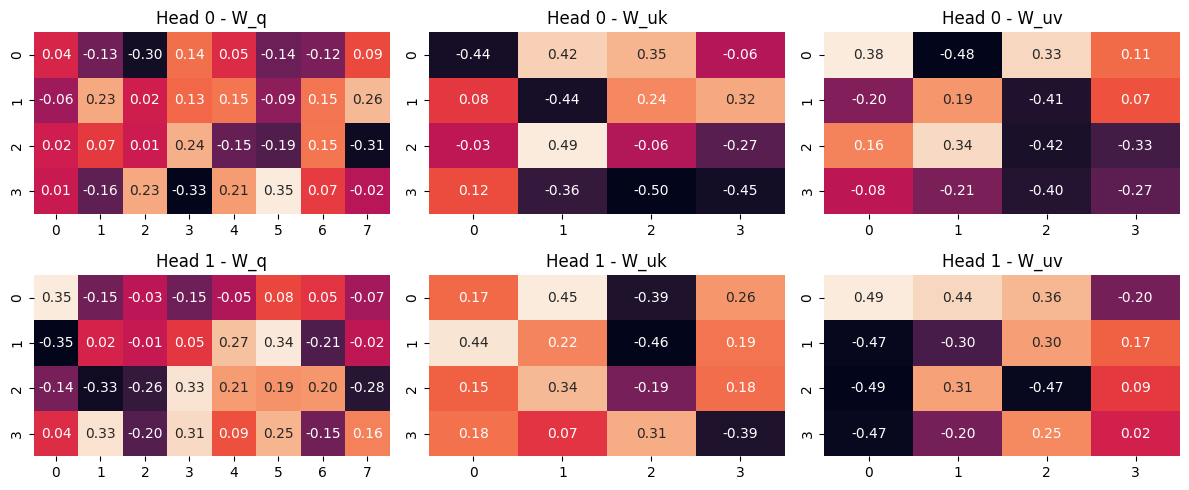

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns 
class MLA(nn.Module):
    def __init__(self,d_model,n_heads,kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads ## dim per head
        
        ## Projection layers
        self.W_q   = nn.Linear(d_model,d_model,bias=False)
        self.W_uk  = nn.Linear(kv_latent_dim,d_model,bias=False)
        self.W_uv  = nn.Linear(kv_latent_dim,d_model,bias=False)
     
model = MLA(d_model=8,n_heads=2,kv_latent_dim=4)

## extract weights 
W_q = model.W_q.weight.detach().numpy()
W_uk = model.W_uk.weight.detach().numpy()
W_uv = model.W_uv.weight.detach().numpy()

## split per head
n_heads = model.n_heads
dh = model.dh
W_q_heads = W_q.reshape(n_heads,dh,-1)
W_uk_heads = W_uk.T.reshape(n_heads,dh,-1)
W_uv_heads = W_uv.T.reshape(n_heads,dh,-1)

## Plot heatmaps
fig , axes = plt.subplots(n_heads,3,figsize=(12,5))
for h in range(n_heads):
    sns.heatmap(W_q_heads[h],ax=axes[h,0],cbar=False,annot=True,fmt="0.2f")
    axes[h,0].set_title(f"Head {h} - W_q") 
    
    sns.heatmap(W_uk_heads[h],ax=axes[h,1],cbar=False,annot=True,fmt="0.2f")
    axes[h,1].set_title(f"Head {h} - W_uk") 
    
    sns.heatmap(W_uv_heads[h],ax=axes[h,2],cbar=False,annot=True,fmt="0.2f")
    axes[h,2].set_title(f"Head {h} - W_uv") 
plt.tight_layout()
plt.show()

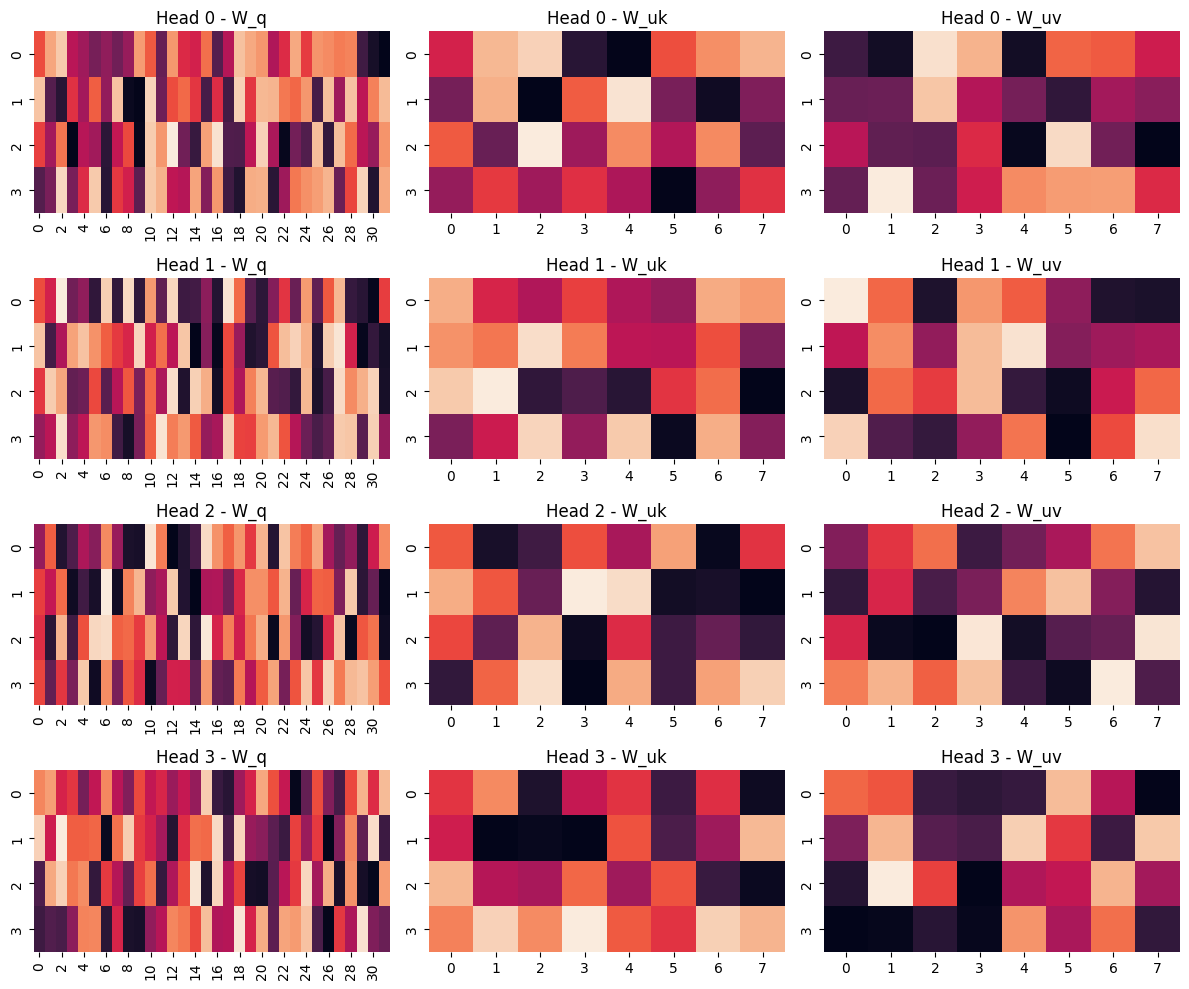

In [ ]:
"""
Model dimension: d_model = 32
Number of heads: n_heads = 8  ⇒ head_dim = d_model / n_heads = 4

W_q: nn.Linear(d_model, d_model)
- Weight shape: (32, 32)
- After projecting x → Q with shape (B, S, 32), we reshape/split:
  Q → (B, S, 8, 4) → (B, 8, S, 4)
- Conceptually, W_q can be viewed as 8 per-head blocks of shape (4, 32).

W_uk, W_uv: nn.Linear(L, d_model)   [where L = kv_latent_dim]
- Weight shapes: (32, L)
- After projecting the latent C_kv → K’/V’ with shape (B, S_total, 32), we reshape/split:
  (B, S_total, 32) → (B, 8, S_total, 4)
- Conceptually, each has 8 per-head blocks of shape (4, L).

From the visualization, we observe that the parameters of W_uk and W_uv differ across heads. 
This contrasts with MQA and GQA, where the key/value projections are shared across heads (either fully or within groups). 
The head-specific projections in our model allow each head to learn distinct transformations of the latent representation, 
which can improve the model’s ability to capture diverse relationships between tokens.
"""
import matplotlib.pyplot as plt
import seaborn as sns 
class MLA(nn.Module):
    def __init__(self,d_model,n_heads,kv_latent_dim):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.dh = d_model // n_heads ## dim per head
        
        ## Projection layers
        self.W_q   = nn.Linear(d_model,d_model,bias=False)
        self.W_uk  = nn.Linear(kv_latent_dim,d_model,bias=False)
        self.W_uv  = nn.Linear(kv_latent_dim,d_model,bias=False)
     
model = MLA(d_model=32,n_heads=8,kv_latent_dim=8)

## extract weights 
W_q = model.W_q.weight.detach().numpy()
W_uk = model.W_uk.weight.detach().numpy()
W_uv = model.W_uv.weight.detach().numpy()

## split per head
n_heads = model.n_heads
dh = model.dh
W_q_heads = W_q.reshape(n_heads,dh,-1)
W_uk_heads = W_uk.T.reshape(n_heads,dh,-1)
W_uv_heads = W_uv.T.reshape(n_heads,dh,-1)

## Plot heatmaps
fig , axes = plt.subplots(4,3,figsize=(12,10))
for h in range(4):
    sns.heatmap(W_q_heads[h],ax=axes[h,0],cbar=False)
    axes[h,0].set_title(f"Head {h} - W_q") 
    
    sns.heatmap(W_uk_heads[h],ax=axes[h,1],cbar=False)
    axes[h,1].set_title(f"Head {h} - W_uk") 
    
    sns.heatmap(W_uv_heads[h],ax=axes[h,2],cbar=False)
    axes[h,2].set_title(f"Head {h} - W_uv") 
plt.tight_layout()
plt.show()